# Deep-Learning method

## 1. Import the necessary libs we might use below.

In [1]:
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import sys
import math
import random

torch.manual_seed(44)
np.random.seed(44)

## 2. Load the dataset

We store the dataset from the dataset website of DEAP (Link: [Dataset of DEAP](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/)), and the dataset is an open source on kaggle now. And we can review the dataset in time slot for first three trial, which includes four dimentions (valence, arousal, dominance, liking).

loading first test data...
,
, data key: dict_keys(['labels', 'data'])
,EEG data shape: (40, 40, 8064)
,label shape: (40, 4)


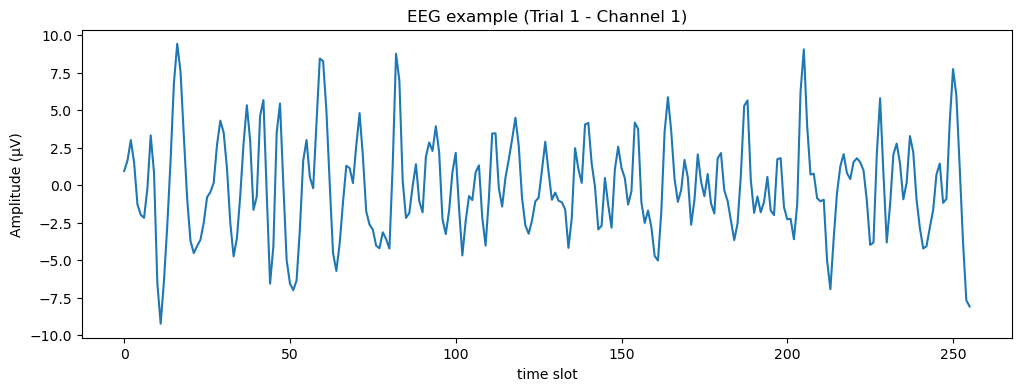


, first three trial (valence, arousal, dominance, liking):
,Trial 1: [7.71 7.6  6.9  7.83]
,Trial 2: [8.1  7.31 7.28 8.47]
,Trial 3: [8.58 7.54 9.   7.08]


In [3]:
#data preview
def load_deap_pickle(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

print("loading first test data...")
sample_file = "data_preprocessed_python/s01.dat"
try:
    sample_data = load_deap_pickle(sample_file)
    print("\n data key:", sample_data.keys())
    print("EEG data shape:", sample_data['data'].shape)  # (40 trials, 40 channels, 8064 points)
    print("label shape:", sample_data['labels'].shape)   # (40 trials, 4)
    
    # visualiza first trial'EEG signal
    plt.figure(figsize=(12, 4))
    plt.plot(sample_data['data'][0, 0, :256])
    plt.title("EEG example (Trial 1 - Channel 1)")
    plt.xlabel("time slot")
    plt.ylabel("Amplitude (μV)")
    plt.show()
    
    # print first 3 trial's tag
    print("\n first three trial (valence, arousal, dominance, liking):")
    for i in range(3):
        print(f"Trial {i+1}: {sample_data['labels'][i]}")
except Exception as e:
    print(f"load error: {str(e)}")

## 3. Feature construction and data preprocessing

Althought Deep-Learing method althought use the Feature Distribution like machine method, the way of procession is different. We use **Wavelet transform** here and calculate differential entropy. The steps are as follows:
1. Data preparation and parameter definition:
Define EEG frequency bands: Use the dictionary **BANDS** to divide the frequency range into 5 bands (delta, theta, alpha, beta, gamma). Select the frontal channel: Specify frontal_channels (electrode channel number) and channel_names (electrode name), focusing on the 4 channels in the frontal area (Fp1, Fp2, AF3, AF4). Initialize the storage structure: Create all_features and all_labels lists to store feature matrices and labels respectively.
2. Data loading and traversal:
Traversal of 32 subjects: Loop to read data files with the file name format of s{subj:02d}.dat (such as s01.dat, s02.dat). Load data: Use pickle to load the data of each subject. The data format is a dictionary containing data (EEG signal) and labels (labels). Traversal of 40 experiments: Process 40 independent experiments for each subject.
3. Channel data extraction:
Extract the frontal channel signal: from the EEG data of each trial, only retain the 4 frontal channel data corresponding to frontal_channels (the shape is 4x the number of sampling points).
4. Wavelet transform and frequency band decomposition:
Wavelet decomposition: Use db4 wavelet to perform 5-layer discrete wavelet transform (DWT) on the EEG signal of each channel to obtain coefficients of different frequency bands:
*delta: 5th layer detail coefficient (1-4 Hz)*\
*theta: 4th layer detail coefficient (4-8 Hz)*\
*alpha: 3rd layer detail coefficient (8-14 Hz)*\
*beta: 2nd layer detail coefficient (14-30 Hz)*\
*gamma: 1st layer detail coefficient (30-50 Hz)*
5. Feature calculation (differential entropy)
Calculate differential entropy (DE): For the coefficient of each frequency band, calculate its differential entropy by the formula 
$DE=0.5⋅ln(2πe⋅variance)$ Feature organization: Each channel generates 5 DE features (corresponding to 5 frequency bands), and the feature matrix of each trial is 4 channels x 5 frequency bands (shape 4x5).

In [5]:
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8), 
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 50)
}

frontal_channels = [1, 17, 2, 18]  #  channel num of Fp1, Fp2, AF3, AF4
channel_names = ["Fp1", "Fp2", "AF3", "AF4"]

all_features = []
all_labels = []

In [7]:
# data preprocessing
print("\n preprocessing data...")

for subj in range(1, 33):  # s01-s32
    filename = f'data_preprocessed_python/s{subj:02d}.dat'
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    for trial in range(40):
        trial_data = data['data'][trial, frontal_channels, :]
        trial_label = data['labels'][trial]
        
        trial_features = []
        
        for ch in range(4):
            ch_data = trial_data[ch]
            
            # wavelet transform
            coeffs = pywt.wavedec(ch_data, 'db4', level=5)
            delta = coeffs[4]  # 1-4Hz
            theta = coeffs[3]  # 4-8Hz
            alpha = coeffs[2]  # 8-14Hz
            beta = coeffs[1]   # 12-30Hz
            gamma = coeffs[0]  # 30-60Hz
            
            # calculate Differential Entropy(DE)
            def compute_de(signal):
                return 0.5 * np.log(2 * np.pi * np.e * np.var(signal))
            
            trial_features.append([
                compute_de(delta),
                compute_de(theta), 
                compute_de(alpha),
                compute_de(beta),
                compute_de(gamma)
            ])
        
        # emotion classify (base on valence and arousal)
        valence, arousal = trial_label[0], trial_label[1]
        if valence >= 5 and arousal >= 5:
            label = 0  # happy/exciting
        elif valence >= 5 and arousal < 5:
            label = 1  # relaxing/peaceful
        elif valence < 5 and arousal >= 5:
            label = 2  # angry/stressed
        else:
            label = 3  # sad/bored
            
        all_features.append(np.array(trial_features))
        all_labels.append(label)

features = np.array(all_features)  # (1280, 4, 5)
labels = np.array(all_labels)      # (1280,)
print(f"label_num: {len(labels)}")
print(f"characteristic matrix's shape: {features.shape}")
print("matrix example:\n", features[0])
print("label example:\n", labels)
print(f"\n finished,total sample number: {features.shape[0]}")


, preprocessing data...
,label_num: 1280
,characteristic matrix's shape: (1280, 4, 5)
,matrix example:
, [[2.91322594 3.39463952 3.59708747 2.78553729 1.94882317]
, [2.81710625 3.33259282 3.64271199 2.83677541 1.50875782]
, [2.92969852 3.46034872 3.66429607 2.8346547  2.23422281]
, [2.82556711 3.41324189 3.66818806 2.77417052 1.91500917]]
,label example:
, [0 0 0 ... 2 2 1]
,
, finished,total sample number: 1280


We define the label classification by valence and arousal (0-3):\
Label 0: High valence (≥5) and high arousal (≥5) → Excited/happy.\
Label 1: High valence (≥5) and low arousal (<5) → Relaxed/calm.\
Label 2: Low valence (<5) and high arousal (≥5) → Angry/stressed.\
Label 3: Low valence (<5) and low arousal (<5) → Sad/bored.\
After prepocessing the data and labels, we plot the feature distributions and DE values.


,Plotting feature distributions...


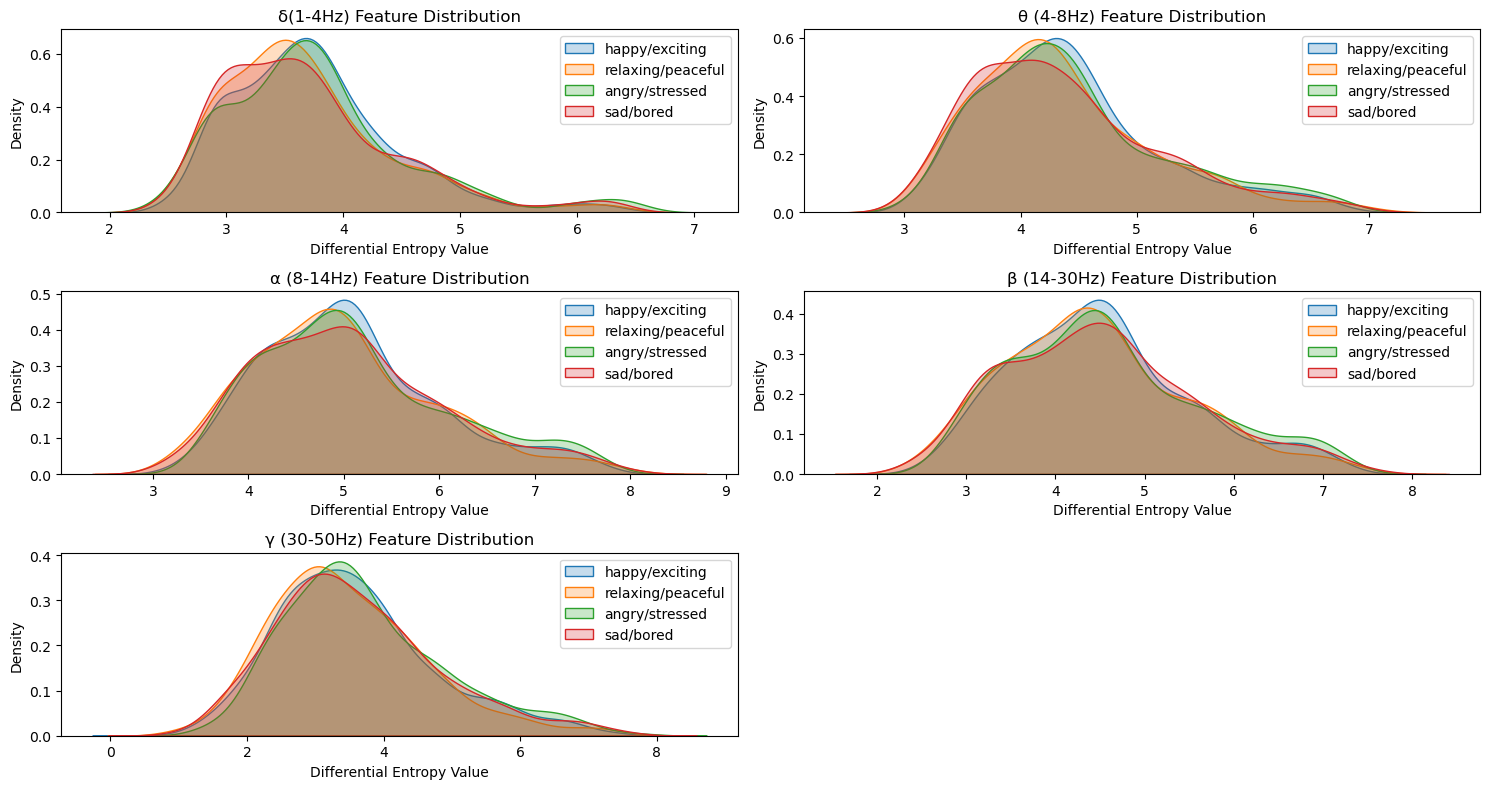

In [9]:
# Part 3: Feature Visualization
print("\nPlotting feature distributions...")
plt.figure(figsize=(15, 8))
band_names = ['δ(1-4Hz)', 'θ (4-8Hz)', 'α (8-14Hz)', 'β (14-30Hz)', 'γ (30-50Hz)']
emotion_labels = ['happy/exciting', 'relaxing/peaceful', 'angry/stressed', 'sad/bored']

for i in range(5):  
    plt.subplot(3, 2, i+1)  # Changed to 3 rows x 2 columns layout
    for emotion in range(4):
        sns.kdeplot(features[labels==emotion, :, i].flatten(), 
                    label=emotion_labels[emotion], fill=True)
    plt.title(f'{band_names[i]} Feature Distribution')
    plt.xlabel('Differential Entropy Value')
    plt.ylabel('Density')
    plt.legend()

# Hide the last empty subplot (position 6) if we have odd number of plots
if len(band_names) % 2 != 0:
    plt.subplot(3, 2, 6)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Constructing Graph-Structured Data (Revised Version)

According to the GAT model theory, we should build the graph-structure. 

In [10]:
# Part 4: Constructing Graph-Structured Data (Revised Version)
print("\nConstructing graph-structured data...")

# Build fully connected graph
edge_index = torch.tensor([
    [0,0,0,1,1,1,2,2,2,3,3,3],  # source nodes
    [1,2,3,0,2,3,0,1,3,0,1,2]    # target nodes
], dtype=torch.long)

graph_data_list = []
for i in range(features.shape[0]):
    x = torch.tensor(features[i], dtype=torch.float)
    y = torch.tensor([labels[i]], dtype=torch.long)
    graph_data_list.append(Data(x=x, edge_index=edge_index, y=y))

# Split train-test sets
train_data, test_data = train_test_split(graph_data_list, test_size=0.125, stratify=labels, random_state=44)
print(f"Training set: {len(train_data)} samples, Test set: {len(test_data)} samples")

# Create DataLoader (using new API)
train_loader = DataLoader(train_data, batch_size=40, shuffle=True)
test_loader = DataLoader(test_data, batch_size=40, shuffle=False)

# Verify data loading
sample = next(iter(train_loader))
print("\nValidating batch data shapes:")
print(f"Node features: {sample.x.shape}")
print(f"Edge index: {sample.edge_index.shape}")
print(f"Labels: {sample.y.shape}")


,Constructing graph-structured data...
,Training set: 1120 samples, Test set: 160 samples
,
,Validating batch data shapes:
,Node features: torch.Size([160, 5])
,Edge index: torch.Size([2, 480])
,Labels: torch.Size([40])


D:\conda\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
,  warnings.warn(out)


## 5. Define GAT Model

We define a graph neural network (GAT) model for processing graph data.
1. First, a GATModel class is defined, which inherits from *PyTorch's nn.Module*. In the constructor, the model structure is constructed through two GATConv graph convolution operations and related activation functions, pooling layers, etc.
2. Specifically: the first layer of graph convolution operation: Use 8 attention heads to convert the input feature dimension from num_features to **16×8**, and process it through BatchNorm and Leaky ReLU activation functions, and then apply Dropout to prevent overfitting.
3. The second layer of graph convolution operation: Also set 8 attention heads to map the features to the num_classes dimension.
4. Pooling and classification: Use *global_mean_pool* for graph-level pooling, and then classify through the fully connected layer and **Softmax**.
5. Finally, we create a model instance and specify the number of input features as *5* and the number of categories as 4, place the model on an available device (GPU or CPU), initialize the optimizer, set different learning rates for different layers, and add weight decay to optimize the model parameters.

In [11]:
# Part 5: Define GAT Model
class GATModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GATConv(num_features, 16, heads=8, concat=True, bias=True, add_self_loops=True)
        self.conv2 = GATConv(16*8, num_classes, heads=8, concat=True, bias=True, add_self_loops=True)
        self.bn1 = nn.BatchNorm1d(16*8)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(32, 4)  # 4 is number of channels, 32 is 4 * 8
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(num_features=5, num_classes=4).to(device)
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': 0.01},
    {'params': model.conv2.parameters(), 'lr': 0.005}
], weight_decay=5e-4)

In [12]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 12, 7)
,PyTorch version: 2.6.0+cpu
,Device: cpu


## 5. Train GAT Model and evaluation

We set reasonable parameters to train the model for 100 epoches. After each round of training and testing, print the current round, training loss, test accuracy and training accuracy. We changed the model parameter settings by updating the model parameters through optimizers (such as SGD, Adam, etc.), and explored and adjusted the model training effect and convergence speed through the selection of optimizers and their parameters (such as learning rate, etc.). The final accuracy is hiher than the SVM, which is closed to *80%* almost.

start training...
,Epoch: 001, Loss: 1.4359, Train Accuracy: 0.39, Test Acc: 0.3188
,Epoch: 002, Loss: 1.3763, Train Accuracy: 0.46, Test Acc: 0.4188
,Epoch: 003, Loss: 1.3635, Train Accuracy: 0.55, Test Acc: 0.4188
,Epoch: 004, Loss: 1.3505, Train Accuracy: 0.60, Test Acc: 0.4375
,Epoch: 005, Loss: 1.3136, Train Accuracy: 0.60, Test Acc: 0.4000
,Epoch: 006, Loss: 1.3060, Train Accuracy: 0.63, Test Acc: 0.4875
,Epoch: 007, Loss: 1.2990, Train Accuracy: 0.62, Test Acc: 0.3688
,Epoch: 008, Loss: 1.2676, Train Accuracy: 0.63, Test Acc: 0.4062
,Epoch: 009, Loss: 1.2491, Train Accuracy: 0.64, Test Acc: 0.4813
,Epoch: 010, Loss: 1.2492, Train Accuracy: 0.65, Test Acc: 0.4188
,Epoch: 011, Loss: 1.2411, Train Accuracy: 0.67, Test Acc: 0.5188
,Epoch: 012, Loss: 1.2247, Train Accuracy: 0.67, Test Acc: 0.5188
,Epoch: 013, Loss: 1.2022, Train Accuracy: 0.69, Test Acc: 0.5563
,Epoch: 014, Loss: 1.2500, Train Accuracy: 0.70, Test Acc: 0.5438
,Epoch: 015, Loss: 1.2085, Train Accuracy: 0.70, Test Acc:

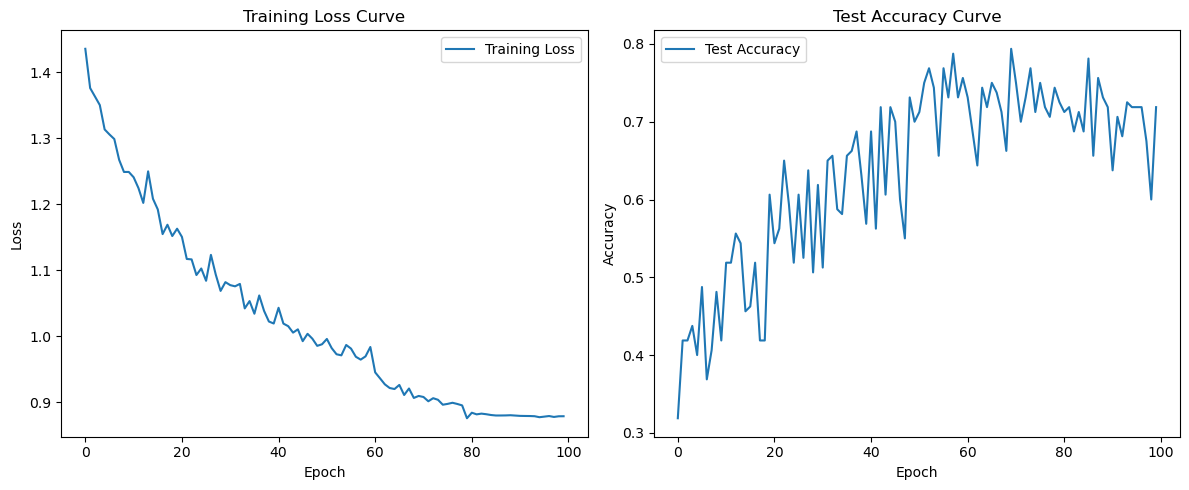

In [13]:
print("start training...")
train_losses = []
test_accuracies = []

for epoch in range(100):
    # train period
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = nn.functional.nll_loss(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # test period
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    test_acc = correct / len(test_loader.dataset)
    test_accuracies.append(test_acc)
    
    print(f'Epoch: {epoch+1:03d}, Loss: {train_loss:.4f}, Train Accuracy: {accuracy:.2f}, Test Acc: {test_acc:.4f}')

print(f'Highest Test Accuracy: {max(test_accuracies):.4f}')
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

We also designed a complete process for model performance evaluation and persistent storage:
1. Get prediction results through forward reasoning and calculate global accuracy.
2. Output fine-grained classification performance reports to help analyze the model's ability to recognize each type of emotion.
3. Save the model weight file for subsequent deployment or continued training.

In [22]:
print("final evaluation...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_true.extend(data.y.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_true))
print(f"\n final accuracy: {test_acc*100:.2f}%")

print("\n classification report:")
print(classification_report(all_true, all_preds, target_names=['happy/exciting', 'relaxing/peaceful', 'angry/stressed', 'sad/bored']))

# model save
torch.save(model.state_dict(), 'eeg_emotion_gat.pth')
print("model has been saved as eeg_emotion_gat.pth")

final evaluation...
,
, final accuracy: 79.38%
,
, classification report:
,                   precision    recall  f1-score   support
,
,   happy/exciting       0.85      0.89      0.87        57
,relaxing/peaceful       0.82      0.79      0.80        33
,   angry/stressed       0.68      0.65      0.66        37
,        sad/bored       0.81      0.82      0.81        33
,
,         accuracy                           0.79       160
,        macro avg       0.78      0.78      0.76       160
,     weighted avg       0.80      0.79      0.78       160
,
,model has been saved as eeg_emotion_gat.pth


# Machine-Learning method

## 1. Import the necessary libs we might use below.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#If GPUS resource premitted, import below libs
# from cuml.svm import SVC as cumlSVC
# from cuml.preprocessing import StandardScaler as cumlStandardScaler
# from cuml.preprocessing import PolynomialFeatures as cumlPolynomialFeatures


## 2. Load the dataset

We store the dataset from the dataset website of DEAP (Link: [Dataset of DEAP](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/)), and the dataset is an open source on kaggle now.

In [ ]:
def read_data(filename):
    with open(filename, 'rb') as f:
        unpickler = pickle._Unpickler(f)
        unpickler.encoding = 'latin1'
        return unpickler.load()

# Generate file names using list comprehension, format: "01", "02", …, "32"
files = [f"{n:02}" for n in range(1, 33)]
# print(files)

base_path = r"/kaggle/input/deap-raw/data_preprocessed_python/s"
# read all files
data_items = [read_data(f"{base_path}{file}.dat") for file in files]

# extract labels and data information
labels = [item['labels'] for item in data_items]
data = [item['data'] for item in data_items]
# print(labels)
# print(data)

Convert data into array format

In [ ]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(32, 40, 4)
,(32, 40, 40, 8064)


In [ ]:
#32 subjects, 40 trials, so 1280 trials in total
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)

(1280, 4)
,(1280, 40, 8064)


## 3. Feature extraction and feature engineering

First, we should reshape the dataset as 40*32=1280 for procession later.

In [ ]:
EEG_data = data[:,:32,:]
print(EEG_data.shape)

(1280, 32, 8064)


We can define the function "bandpower" and "get_band_power" to use the Welch method so that we can obtain the estimated PSD of signal in frequency domin.
**Welch power** spectral density estimation is a spectral estimation method based on signal segment averaging, which can analyse the spectrum of a time-domain signal and obtain the energy distribution of the signal at different frequencies. Welch power spectral density estimation is widely used in signal processing, communication, acoustics and other fields, and has better computational efficiency and estimation accuracy than the traditional spectral estimation methods.\
According to the method, as these algorithms have been packaged into mature library functions for easy calling by the user, there are currently the *Pytorch* method and the joint method of *Welch* and *simpon* in *Scripy*, the latter of which is used in this project.

In [ ]:
# define bandpower function to calculate band power
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simpson(psd[idx_band], dx=freq_res)
    return bp
# Set the frequency range according to the band name and call function bandpower to calculate the power.
def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "delta"):
        bd = (0.5,4)
    if (band == "theta"):
        bd = (4,8)
    elif (band == C):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(EEG_data[people,channel], 128, bd)
# Iterate over all subjects and channels, calculate the power in each band in turn, and store the results in a list
eeg_band = []
for i in range (len(EEG_data)):
    for j in range (len(EEG_data[0])):
        eeg_band.append(get_band_power(i,j,"delta"))
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))

We can check the procession and result of welch method by virtualizing one sample "subject=1,channel=3"

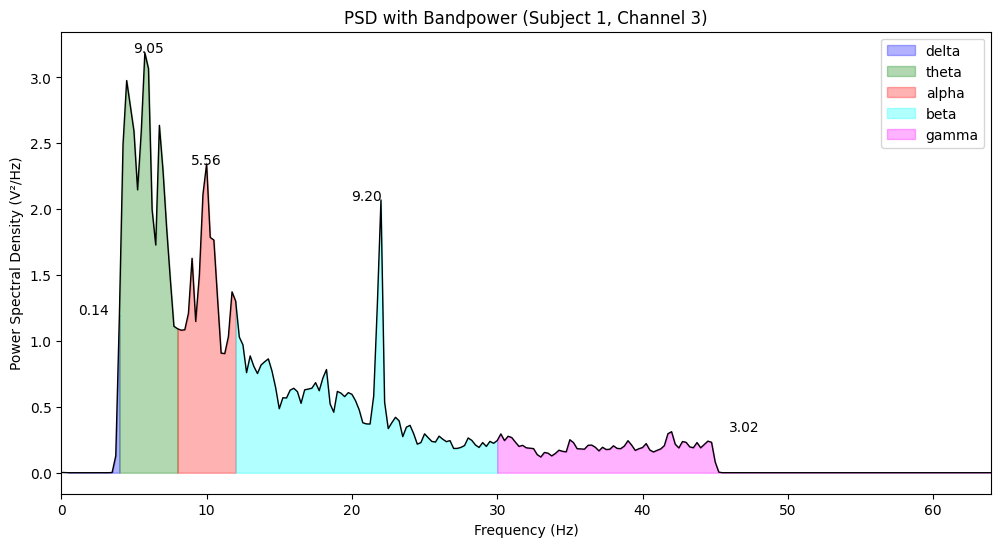

In [ ]:
# select a sample "subject=1,channel=3"
sample_subject = 1
sample_channel = 3
data_temp = EEG_data[sample_subject, sample_channel, :]
sf = 128  # sampling rate

# Calculate PSD (using nperseg of Delta error to ensure low frequency resolution)
low = 0.5
nperseg = int((2 / low) * sf)
freqs, psd = welch(data_temp, sf, nperseg=nperseg)

# plot PSD
plt.figure(figsize=(12, 6))
plt.plot(freqs, psd, color='k', lw=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')

# Define frequency bands and colors
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma": (30, 64)
}
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Highlight each frequency band and mark the power value
for band, color in zip(bands, colors):
    low_freq, high_freq = bands[band]
    mask = (freqs >= low_freq) & (freqs <= high_freq)
    plt.fill_between(freqs, psd, where=mask, color=color, alpha=0.3, label=band)
    # Calculate frequency band power
    freq_res = freqs[1] - freqs[0]
    bp = simpson(psd[mask], dx=freq_res)
    plt.text((low_freq + high_freq)/2, np.max(psd[mask]), f"{bp:.2f}", ha='center')

plt.xlim(0, 64)
plt.legend()
plt.title(f'PSD with Bandpower (Subject {sample_subject}, Channel {sample_channel})')
plt.show()


After obtaining the PSD, we can plot the power of each band on this sample.

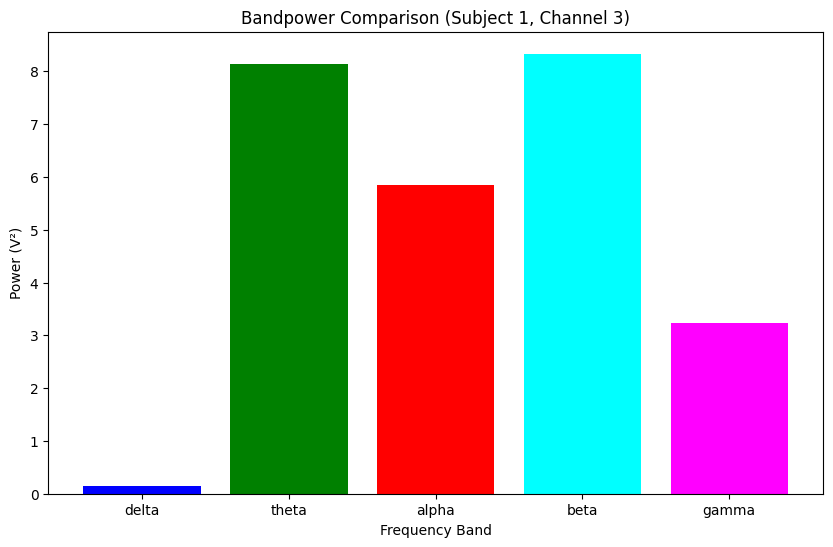

In [ ]:
# Extract the power of the five frequency bands for the example subjects and channels
eeg_band_3d = np.array(eeg_band).reshape(1280, 32, 5)
powers = eeg_band_3d[sample_subject, sample_channel, :]

# Draw a bar chart
plt.figure(figsize=(10, 6))
plt.bar(bands.keys(), powers, color=colors)
plt.xlabel('Frequency Band')
plt.ylabel('Power (V²)')
plt.title(f'Bandpower Comparison (Subject {sample_subject}, Channel {sample_channel})')
plt.show()

We store the extracted dataset and check its shape.

In [ ]:
eeg_band = np.array(eeg_band)
# The list shape should be (1280, 5,32), we need to reshape it to (1280, 160) so that it is convenient for the next step.
EEG_data_band = eeg_band.reshape((1280,160)) # 5×32
print(EEG_data_band.shape)
np.save("EEG_data_band.npy", EEG_data_band)
# print(EEG_data_band[0])

(1280, 160)


## 4. Build label data

In [ ]:
import pandas as pd
#define the labels as binary values as output(4 dimentions)
df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})
df_label

,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
...,...,...,...,...
1275,3.91,6.96,5.82,3.12
1276,2.81,6.13,6.06,1.04
1277,3.05,7.01,5.10,1.10
1278,3.99,7.17,4.85,1.00


In [ ]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1280 entries, 0 to 1279
,Data columns (total 4 columns):
, #   Column     Non-Null Count  Dtype  
,---  ------     --------------  -----  
, 0   Valence    1280 non-null   float64
, 1   Arousal    1280 non-null   float64
, 2   Dominance  1280 non-null   float64
, 3   Liking     1280 non-null   float64
,dtypes: float64(4)
,memory usage: 40.1 KB


In [ ]:
# Look the information of the data set
df_label.describe()

,Valence,Arousal,Dominance,Liking
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [ ]:
label_name = ["valence","arousal","dominance","liking"]
labels_valence = []
labels_arousal = []
labels_dominance = []
labels_liking = []
label_list = [labels_valence, labels_arousal, labels_dominance, labels_liking]
# set the threshold for each label according to the information of the dataset
for la in labels:
    l = []
    if la[0]>5:
        labels_valence.append(1)
    else:
        labels_valence.append(0)
    if la[1]>5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)
    if la[2]>5:
        labels_dominance.append(1)
    else:
        labels_dominance.append(0)
    if la[3]>6:
        labels_liking.append(1)
    else:
        labels_liking.append(0)

In [ ]:
# build DataFrame
data_lableframe = {
    "valence": labels_valence,
    "arousal": labels_arousal,
    "dominance": labels_dominance,
    "liking": labels_liking
}
df = pd.DataFrame(data_lableframe)
placeholder = pd.DataFrame([["..."] * len(df.columns)], columns=df.columns)
# Show first ten lines
df_display = pd.concat([df.head(10), pd.DataFrame([["..."] * len(df.columns)], columns=df.columns)], ignore_index=True)

# print the table for checking
print(df_display)

   valence arousal dominance liking
,0        1       1         1      1
,1        1       1         1      1
,2        1       1         1      1
,3        0       1         1      1
,4        1       0         1      1
,5        1       0         1      1
,6        1       0         1      1
,7        1       0         1      0
,8        0       0         0      0
,9        0       0         0      1
,10     ...     ...       ...    ...


## 5. Model design and construction

In order to get the 4 dimention classification result, we first build a structure array called "rersult" for storing the information and outcome.

In [ ]:
# X dataset
data_x = EEG_data_band
print(data_x.shape)
# Y dataset
results = {
    'train_accuracy': [],
    'test_accuracy': [],
    'f1_scores': [],
    'confusion_matrices': []
}


(1280, 160)


Define the model of SVM.
The thought of designing the model is as follows:
1. Model Initialization and Core Configuration:\
The RBF kernel function is adopted to deal with complex data relationships through nonlinear mapping, taking into account the flexibility and generalization ability. The class_weight='balanced' parameter is introduced to automatically adjust the class weights to alleviate the data imbalance problem and avoid the model being biased towards most classes.
2. Hyperparameter grid search optimization Parameter selection:\
Focus on regulating the regularization parameter C (to control overfitting) and the kernel coefficient gamma (to affect the curvature of the decision boundary). Set **C=[0.01,0.1,1,10,50]** and **gamma=['scale','auto',0.001,0.01,0.1]** to cover the typical range of values. For Cross-validation, **5-fold hierarchical cross-validation (StratifiedKFold)** is used to ensure consistent distribution of data categories per fold and reduce bias. Evaluation metrics: Use F1-score as the optimization target, consider precision rate and recall rate comprehensively, and adapt to unbalanced data scenarios.
3. Model training and evaluation Parallel search for optimal parameter combinations via GridSearchCV, utilizing all CPU cores (n_jobs=-1) to accelerate computation. 
4. Dual evaluation strategy: Cross-validation set: output the average F1 value under the optimal parameters, reflecting the model stability; Independent test set: calculate the accuracy, F1 and confusion matrix to evaluate the generalization performance.


In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test, label_name):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 50],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1] # parameters of RBF
    }
    # Configure 5-fold stratified cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Creating a Grid Searcher with Cross Validation
    grid_search = GridSearchCV(
        estimator=SVC(kernel='rbf', class_weight='balanced'),
        param_grid=param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    # Perform a grid search (note that this should be done on standardized data)
    grid_search.fit(X_train, y_train)
    # Output the best parameter combination
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-val F1: {grid_search.best_score_:.4f}")

    # Prediction results, use the best model for test set evaluation
    best_svc = grid_search.best_estimator_
    y_pred = best_svc.predict(X_test)

    # Calculate indicators
    train_acc = best_svc.score(X_train, y_train)
    test_acc = best_svc.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(12, 6))
    # Plotting the C parameter impact towards F1-score
    plt.subplot(1, 2, 1)
    for gamma in param_grid['gamma']:
        mask = cv_results['param_gamma'] == gamma
        plt.plot(cv_results['param_C'][mask],
                 cv_results['mean_test_score'][mask],
                 marker='o', label=gamma)
    plt.xscale('log')
    plt.xlabel('C (log scale)')
    plt.ylabel('F1-score')
    plt.title('Gamma Parameter Analysis')
    plt.legend(title='Gamma')

    # Plotting the Gamma Parameter Effect towards F1-score
    plt.subplot(1, 2, 2)
    for c in param_grid['C']:
        mask = cv_results['param_C'] == c
        plt.plot(cv_results['param_gamma'][mask].astype(str),
                 cv_results['mean_test_score'][mask],
                 marker='o', label=f'C={c}')
    plt.xlabel('Gamma')
    plt.ylabel('F1-score')
    plt.title('C Parameter Analysis')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'High'],
                yticklabels=['Low', 'High'])
    plt.title(f'Confusion Matrix ({label_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return train_acc, test_acc, f1, cm

## 6. Evaluation of the model and rusults

By performing a grid search, we can obtain the "best parameters" and we can apply it to the model. The figure presents the relation shape of **C** and **gamma* towards F1-score in the training procession.


,==============================
,Processing valence...
,==============================
,Fitting 5 folds for each of 25 candidates, totalling 125 fits
,Best parameters: {'C': 1, 'gamma': 'scale'}
,Best cross-val F1: 0.6894


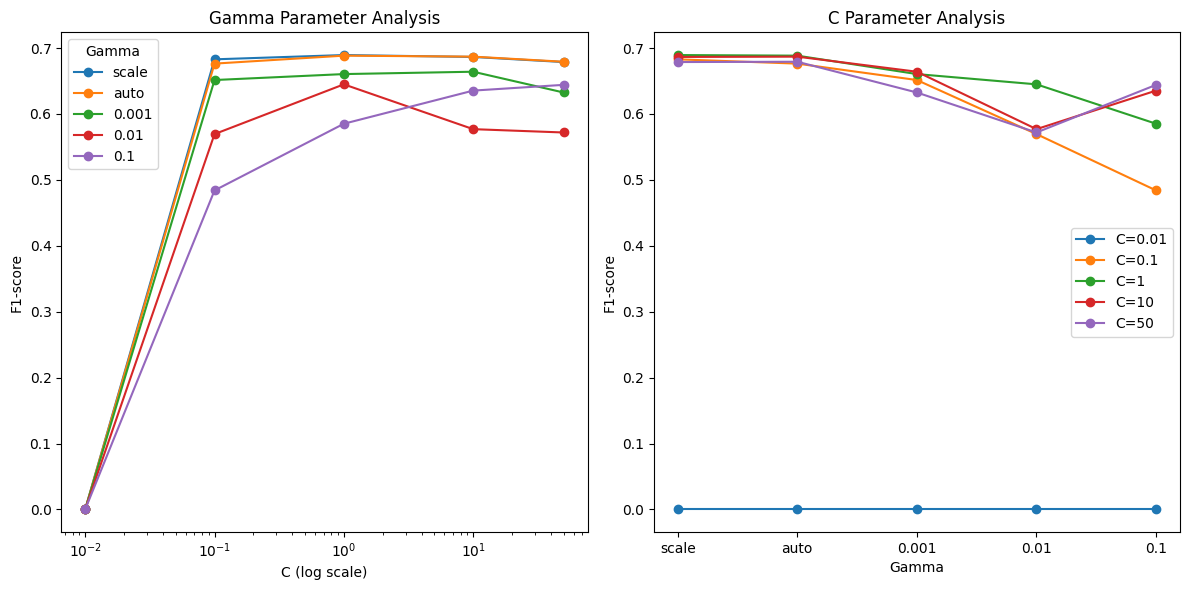

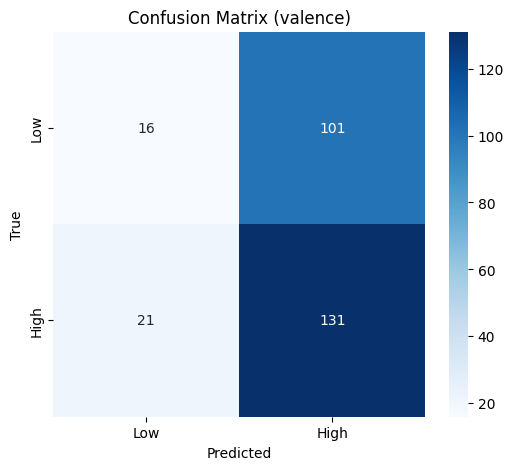

Train Accuracy: 0.5994
,Test Accuracy:  0.5465
,F1-Score:       0.6823
,
,
,==============================
,Processing arousal...
,==============================
,Fitting 5 folds for each of 25 candidates, totalling 125 fits
,Best parameters: {'C': 10, 'gamma': 0.1}
,Best cross-val F1: 0.6856


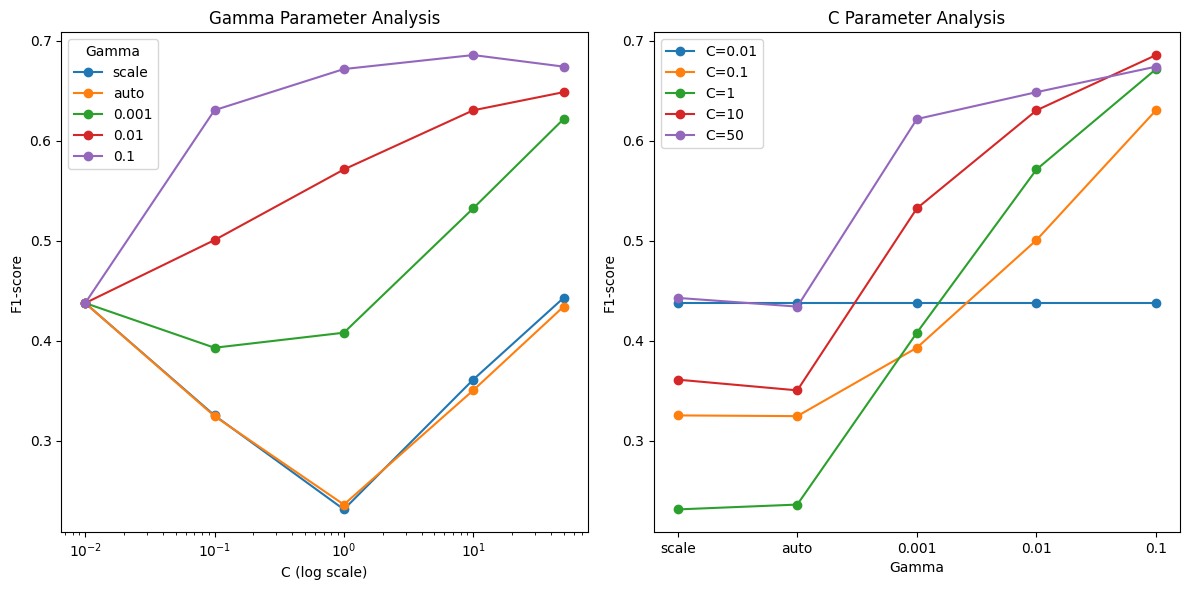

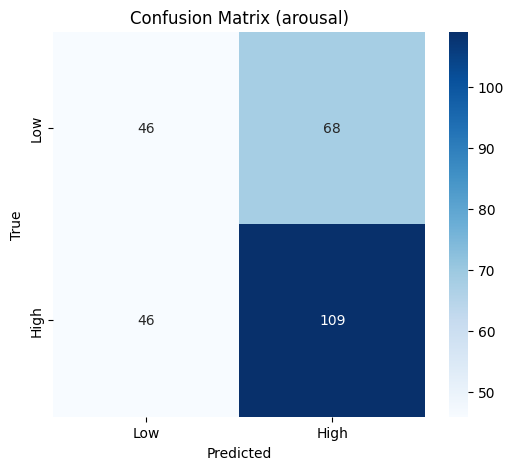

Train Accuracy: 0.8645
,Test Accuracy:  0.5762
,F1-Score:       0.6566
,
,
,==============================
,Processing dominance...
,==============================
,Fitting 5 folds for each of 25 candidates, totalling 125 fits
,Best parameters: {'C': 1, 'gamma': 0.001}
,Best cross-val F1: 0.6914


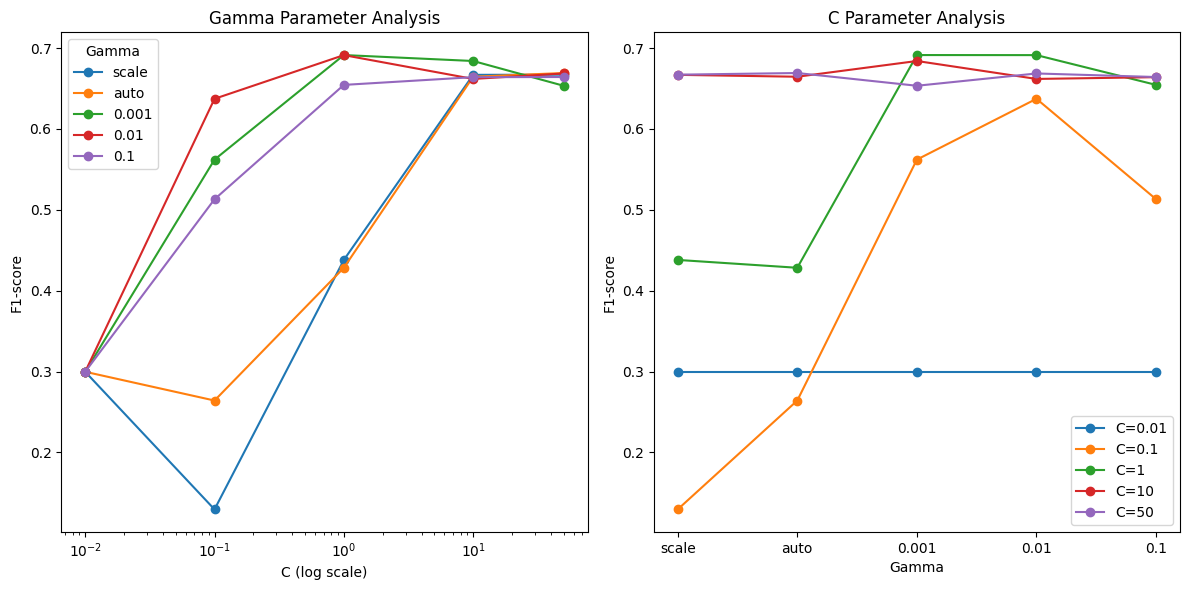

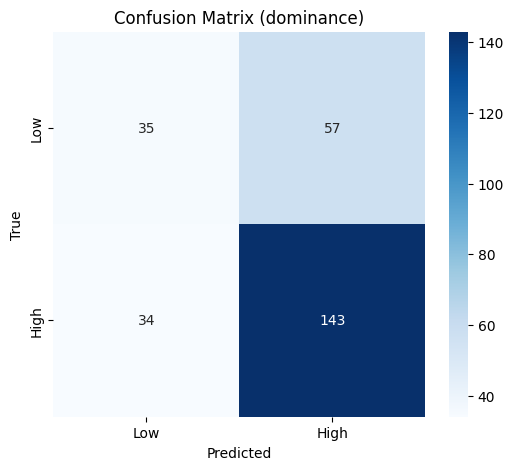

Train Accuracy: 0.6805
,Test Accuracy:  0.6617
,F1-Score:       0.7586
,
,
,==============================
,Processing liking...
,==============================
,Fitting 5 folds for each of 25 candidates, totalling 125 fits
,Best parameters: {'C': 0.1, 'gamma': 'scale'}
,Best cross-val F1: 0.6903


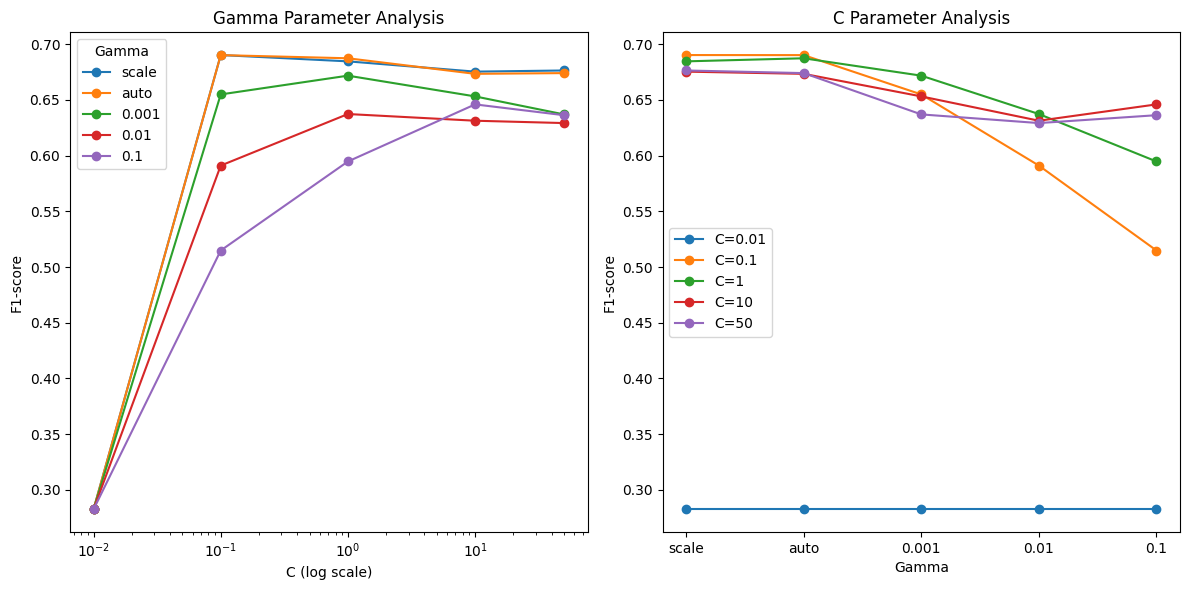

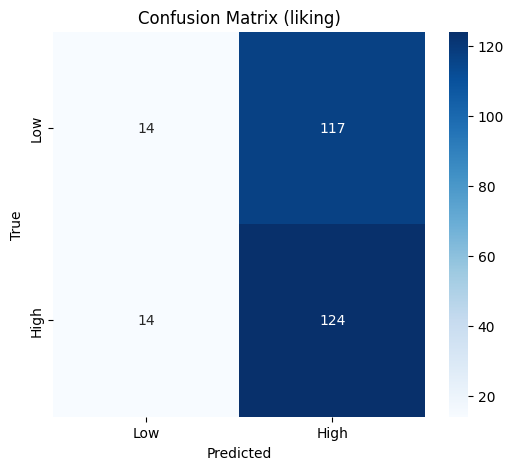

Train Accuracy: 0.5628
,Test Accuracy:  0.5130
,F1-Score:       0.6544
,


In [ ]:
for idx, (label_name, label_y) in enumerate(zip(label_name, label_list)):
    print(f"\n{'=' * 30}")
    print(f"Processing {label_name}...")
    print(f"{'=' * 30}")

    # Dataset segmentation, the segmentation ratio is 0.21
    X_train, X_test, y_train, y_test = train_test_split(
        EEG_data_band, label_y, test_size=0.21, random_state=42)

    # Feature Engineering (make sure to do it after segmentation)
    poly = preprocessing.PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # standardization
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)

    # Evaluation model
    train_acc, test_acc, f1, cm = evaluate_model(
        X_train_scaled, X_test_scaled, y_train, y_test, label_name)

    # Store results
    results['train_accuracy'].append(train_acc)
    results['test_accuracy'].append(test_acc)
    results['f1_scores'].append(f1)
    results['confusion_matrices'].append(cm)

    # Print related results
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"F1-Score:       {f1:.4f}\n")

The table of accuracy of each classification "valence", "arousal", "dominance", "liking".

In [ ]:
# Print the final result table
label_names = ["valence", "arousal", "dominance", "liking"]
result_df = pd.DataFrame({
    'Label': label_names,
    'Train Accuracy': results['train_accuracy'],
    'Test Accuracy': results['test_accuracy'],
    'F1-Score': results['f1_scores']
}).round(4)

print("\nFinal Results:")
print(result_df.to_string(index=False))


,Final Results:
,    Label  Train Accuracy  Test Accuracy  F1-Score
,  valence          0.5994         0.5465    0.6823
,  arousal          0.8645         0.5762    0.6566
,dominance          0.6805         0.6617    0.7586
,   liking          0.5628         0.5130    0.6544


Finally, we can do some visualization for comparation between 4-label classificaion.

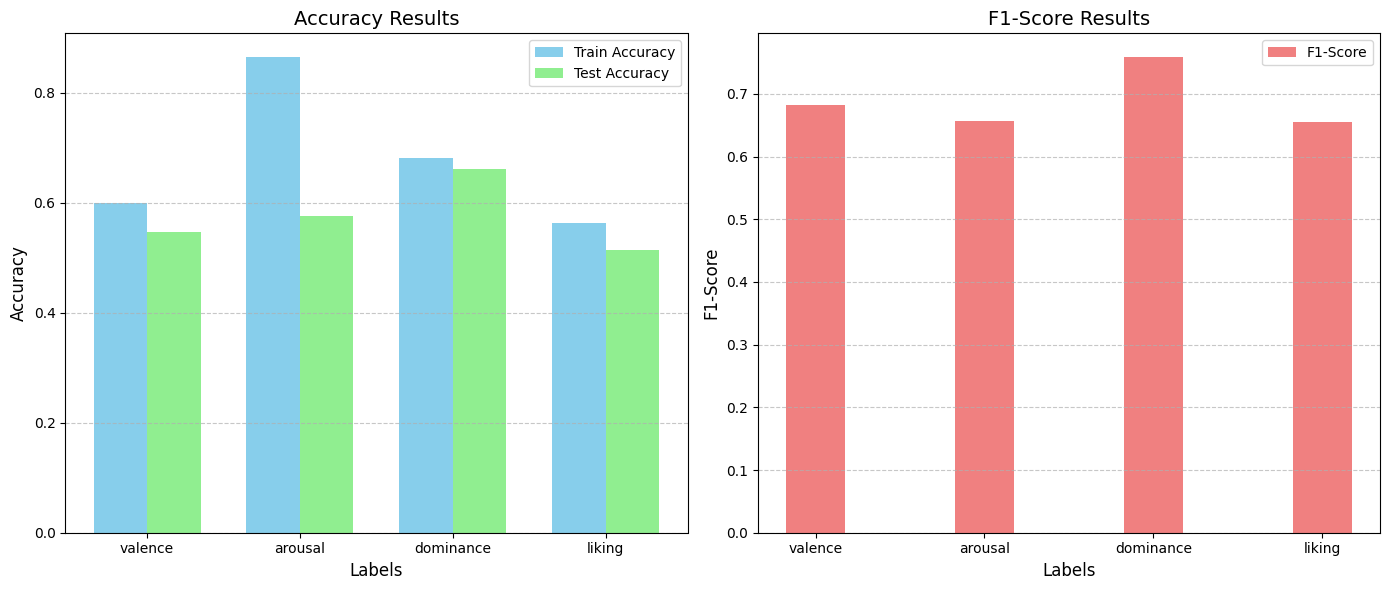

In [ ]:
# Create graphs and subgraphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Set the width and position of the bar chart
bar_width = 0.35
index = np.arange(len(label_names))

# Draw the accuracy subgraph
ax1.bar(index - bar_width/2, result_df['Train Accuracy'], bar_width, label='Train Accuracy', color='skyblue')
ax1.bar(index + bar_width/2, result_df['Test Accuracy'], bar_width, label='Test Accuracy', color='lightgreen')
ax1.set_title('Accuracy Results', fontsize=14)
ax1.set_xlabel('Labels', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xticks(index)
ax1.set_xticklabels(label_names, fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Draw the F1-Score subgraph
ax2.bar(index, result_df['F1-Score'], bar_width, label='F1-Score', color='lightcoral')
ax2.set_title('F1-Score Results', fontsize=14)
ax2.set_xlabel('Labels', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_xticks(index)
ax2.set_xticklabels(label_names, fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# show chart
plt.show()